<a href="https://colab.research.google.com/github/christopher-hsu/latent-map-planning/blob/master/model/jupyter_notebooks/siameseCVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Shared by all
import os, pickle, glob
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils # We should use this eventually.
from torch import nn, optim
from torch.nn import functional as F
import numpy as np


# For DataLoader
from PIL import Image
import numbers

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')     

In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


### Dataset Code: `CarlaDataset.py`

In [0]:
class CarlaDataset(Dataset):
    def __init__(self, data_dir, load_as_grayscale=False, transform=None):
        # xcxc I'm assuming that the images live in _out.
        self.data_dir = data_dir
        self.transform = transform
        self.load_as_grayscale = load_as_grayscale
        self.df = self._get_dataframe()
        
    def __len__(self):
        num_rows, _ = self.df.shape
        return num_rows
    
    def __getitem__(self, idx):
        '''
        Generate one sample of data.
        '''
        # We're gonna do some hardcore hard-coding here.
        # First, extract our control inputs
        row = self.df.iloc[idx]
        imgs_t0, imgs_t1 = self._get_image_tensor_for_row(row)
        control_inputs = np.array([row['ctr1'], row['ctr2']])
    
        return (imgs_t0, imgs_t1, control_inputs)
    
    def _get_image_tensor_for_row(self, row):
        '''
        Inputs:
            row_id: String that represents the input_num
        Outputs:
            A (2 x H x W x 4) 4D matrix of the two images.
        '''
        # The row_id should be the input_num. Should also be a string.
        img_t0_filenames = [row['img1_t0'], row['img2_t0']]
        img_t1_filenames = [row['img1_t1'], row['img2_t1']]
        img_t0_filenames.sort()
        img_t1_filenames.sort()
        t0_images = []
        for ele in img_t0_filenames:
            full_name = os.path.join(self.data_dir, '_out', ele)
            img_as_np_arr = self._load_image_and_maybe_apply_transform(full_name)
            t0_images.append(img_as_np_arr)
        t1_images = []
        for ele in img_t1_filenames:
            full_name = os.path.join(self.data_dir, '_out', ele)
            img_as_np_arr = self._load_image_and_maybe_apply_transform(full_name)
            t1_images.append(img_as_np_arr)
        
        t0_images = np.array(t0_images)
        t1_images = np.array(t1_images)
        return t0_images, t1_images

    def _load_image_and_maybe_apply_transform(self, image_loc):
        '''
        Inputs:
            image_loc: The location of the image we want to load
        Outputs:
            Either the grayscale image, a RGB image with the axes flopped, or 
            the RGB image with some series of transformations applied. 
            All are converted to numpy arrays before yeeting them out.
        '''
        # I've been writing too much haskell
        pil_img = Image.open(image_loc)
        if self.load_as_grayscale:
            pil_img = pil_img.convert('L')
        
        if self.transform:
            transform_result = self.transform(pil_img)
            return np.asarray(transform_result[:3, :, :])
        else:
            if self.load_as_grayscale:
                return np.array(pil_img)
            else:
                return self._rearrange_axes_image(np.array(pil_img))

    def _rearrange_axes_image(self, img):
        H,W,_ = img.shape
        new_img = np.zeros((3,H,W))
        for i in range(3):
            new_img[i,:,:] = img[:,:,i]
        return new_img

    def _get_dataframe(self):
        control_input_df = self._get_control_input_df()
        filename_df = self._get_image_path_df()
        df = control_input_df.merge(right=filename_df,
                                    left_on=['trajectory','input_num'],
                                    right_on=['trajectory', 'index'])
        df = df.drop_duplicates() # I have no idea why we have dupes
        
        stationary_mask = df['img1_t0'] == df['img1_t1']
        ctr1_col = df['ctr1'].copy()
        ctr2_col = df['ctr2'].copy()
        ctr1_col[stationary_mask] = 0
        ctr2_col[stationary_mask] = 0
        df['ctr1'] = ctr1_col
        df['ctr2'] = ctr2_col
        return df

    def _get_control_input_df(self):
        # xcxc I'm also assuming that our columns in control_input stay static like so.
        control_input_df = pd.read_csv(os.path.join(self.data_dir, 'control_input.txt'),
                               names=['trajectory', 'input_num', 'ctr1', 'ctr2'])
        control_input_df['input_num'] = control_input_df['input_num'].astype('int')
        control_input_df['trajectory'] = control_input_df['trajectory'].astype('str')
        return control_input_df
    
    def _get_image_path_df(self):
        filename_groupings = self._get_filename_groupings()
        filename_df = self._get_initial_filename_dataframe(filename_groupings)
        timestep_df = self._get_filename_dataframe_with_steps(filename_df)
        return timestep_df
    
    def _get_files_in_out(self):
        full_data = glob.glob(os.path.join(self.data_dir, '_out', '**.png'))
        abbrev_data = [x.split('/')[-1] for x in full_data]
        return abbrev_data
    
    def _get_filename_groupings(self):
        '''
        Reads in all the filenames, then groups them by
        (trajectory, timestep): [images]
        '''
        # A little cryptic, but it just gets the list of all filenames
        all_files_in_out = self._get_files_in_out()
        
        # We can then make a map with our data...
        filename_groupings = {}
        for fn in all_files_in_out:
            # Apologies for the hardcoding
            fn_number = str(int(fn.split('_')[0]))
            trajectory_number = str(int(fn.split('_')[2].split('.')[0]))
            if (fn_number, trajectory_number) not in filename_groupings:
                filename_groupings[(fn_number, trajectory_number)] = []
            filename_groupings[(fn_number, trajectory_number)].append(fn)
        return filename_groupings
    
    def _get_initial_filename_dataframe(self, filename_groupings):
        '''
        Given the filename groupings from the above, create a dataframe
        of the schema [trajectory, index, image1, image2]
        '''
        filename_df = pd.DataFrame(columns=['trajectory', 'index', 'img1', 'img2'])
        for k,v in filename_groupings.items():
            (index, traj) = k
            img1, img2 = None, None
            v.sort()
            if len(v) == 2:
                img1, img2 = v[0], v[1]
            elif len(v) == 1:
                img1 = v[0]
            filename_df = filename_df.append({
                'trajectory': traj,
                'index': index,
                'img1': img1,
                'img2': img2
            }, ignore_index=True)
        filename_df['trajectory'] = filename_df['trajectory'].astype('str')
        filename_df['index'] = filename_df['index'].astype('int')
        filename_df = filename_df.dropna(subset=['img1','img2']) # Drop if any of our images is None.
        return filename_df
    
    def _get_filename_dataframe_with_steps(self, filename_df):
        '''
        Given the filename df from the above, loop through it and get 
        the (t,t) and (t, t+1) pairings.
        '''
        schema = [
            'trajectory',
            'index',
            'img1_t0',
            'img2_t0',
            'img1_t1',
            'img2_t1']
        timestep_df = pd.DataFrame(columns=schema)
        num_rows, _ = filename_df.shape
        for i in range(num_rows): # blah blah yeah i know i'm not vectorizing. 
            ith_row = filename_df.iloc[i]
            row_dict = {
                'trajectory': ith_row['trajectory'],
                'index': ith_row['index'],
                'img1_t0': ith_row['img1'],
                'img2_t0': ith_row['img2']
            }
            # First, construct the stationary row
            stationary_row = row_dict.copy()
            stationary_row['img1_t1'] = ith_row['img1']
            stationary_row['img2_t1'] = ith_row['img2']
            timestep_df = timestep_df.append(stationary_row, ignore_index=True)
            # Then, construct the t+1th row IF it exists
            next_timestep_row = self._construct_next_timestep_row(
                row_dict, ith_row, filename_df)
            timestep_df = timestep_df.append(next_timestep_row, ignore_index=True)
        timestep_df['trajectory'] = timestep_df['trajectory'].astype('str')
        timestep_df['index'] = timestep_df['index'].astype('int')
        return timestep_df

    def _construct_next_timestep_row(self, row_dict, ith_row, filename_df):
        delta = 4
        next_index = ith_row['index'] + delta
        mask = (filename_df['index'] == next_index) & (filename_df['trajectory'] == ith_row['trajectory'])
        res = filename_df[mask]
        num_results = len(res)
        if num_results > 1:
            print("THERE'S MORE THAN ONE RESULT WHEN MAKING THE DATAFRAME")
        if num_results == 1:
            next_step_row = row_dict.copy()
            next_step_row['img1_t1'] = res['img1'].values[0]
            next_step_row['img2_t1'] = res['img2'].values[0]
            return next_step_row
        return None

### Model: `siameseCVAE.py` (xcxc To be changed later)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')     

In [0]:
class siameseCVAE(nn.Module):
	def __init__(self,batch=4):
		super().__init__()
		d = 0.4
		self.z_size = 64
		self.small = 256
		self.hidden = 1024
		ch_sz = 1
		c1 = 64
		c2 = 16
		last_conv = 4
		self.tensor = (batch,last_conv,150,200)
		flat = np.prod(self.tensor)
		flat2 = flat*2

		# channel_in, c_out, kernel_size, stride, padding
		def convbn(ci,co,ksz,s=1,pz=0):		#ReLu nonlinearity
			return nn.Sequential(
				nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
				nn.ReLU(),
				nn.BatchNorm2d(co))
		def convout(ci,co,ksz,s=1,pz=0):	#Sigmoid nonlinearity
			return nn.Sequential(
				nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
				nn.Sigmoid(),
				nn.BatchNorm2d(co))
		def mlp(in_size,hidden):
			return nn.Sequential(
				nn.Dropout(d),
				nn.Linear(in_size,hidden),
				nn.ReLU())

		#Encoder NN
		self.encx = nn.Sequential(
				nn.Dropout(d),
				convbn(ch_sz,c1,3,1,1),
				convbn(c1,c2,3,1,1),
				convbn(c2,last_conv,3,1,1))
		self.ency = nn.Sequential(
				nn.Dropout(d),
				convbn(ch_sz,c1,3,1,1),
				convbn(c1,c2,3,1,1),
				convbn(c2,last_conv,3,1,1))
		self.m1 = nn.Sequential(
				nn.Dropout(d),
				mlp(flat2,self.hidden),
				mlp(self.hidden, self.small))
		self.zmean = nn.Linear(self.small,self.z_size)
		self.zlogvar = nn.Linear(self.small,self.z_size)

		#Decoder NN
		self.expand_z = nn.Linear(self.z_size,self.small)
		self.mx = nn.Sequential(
				nn.Dropout(d),
				mlp(self.small,self.hidden),
				mlp(self.hidden,flat))
		self.my = nn.Sequential(
				nn.Dropout(d),
				mlp(self.small,self.hidden),
				mlp(self.hidden,flat))
		self.decx = nn.Sequential(
				nn.Dropout(d),
				convbn(last_conv,c2,3,1,1),
				convbn(c2,c1,3,1,1),
				convout(c1,ch_sz,3,1,1))
		self.decy = nn.Sequential(
				nn.Dropout(d),
				convbn(last_conv,c2,3,1,1),
				convbn(c2,c1,3,1,1),
				convout(c1,ch_sz,3,1,1))

	def encoder(self, x, y):
		# Flatten enc output
		h_x = self.encx(x).view(-1)
		h_y = self.ency(y).view(-1)
		# Concatenate flat convs
		h_layer = torch.cat((h_x,h_y))
		h = self.m1(h_layer)
		return h

	def bottleneck(self, x):
		z_mean = self.zmean(x)
		z_logvar = self.zlogvar(x)
		#reparam to get z latent sample
		std = torch.exp(0.5*z_logvar)
		eps = torch.randn_like(std)
		z = z_mean + eps*std
		return z, z_mean, z_logvar

	def decoder(self, z):
		#check the nonlinearities of this layer
		h = self.expand_z(z)
		#exand z to each decoder head
		h_x = self.mx(h)
		h_y = self.my(h)
		#make sure to reshape data correctly and decode
		x = self.decx(h_x.view(self.tensor))
		y = self.decy(h_x.view(self.tensor))
		return x, y

	def forward(self, x, y):
		h = self.encoder(x, y)
		z, z_mean, z_logvar = self.bottleneck(h)
		x_hat, y_hat = self.decoder(z)
		return x_hat, y_hat, z, z_mean, z_logvar

	def encode_get_z(self, x, y):
		h = self.encoder(x, y)
		z, z_mean, z_logvar = self.bottleneck(h)
		return z, z_mean, z_logvar

In [0]:
def _rearrange_channel_last(img, color = False):
    _,_,H,W = img.shape
    if color == True:
        new_img = np.zeros((H,W,3))
        for i in range(3):
            new_img[:,:,i] = img[0,i,:,:]
    else:
        new_img = np.zeros((H,W))
        new_img[:,:] = img[0,0,:,:]
    return new_img

def ELBO_loss(xhat, x, yhat, y, mu, logvar):
    mseloss = nn.MSELoss(reduction='sum')
    MSE_X = mseloss(xhat, x)
    MSE_Y = mseloss(yhat, y)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE_X+MSE_Y+KLD, MSE_X, MSE_Y, KLD

In [0]:
transform = transforms.Compose([
        transforms.Resize((150,200)),
        transforms.ToTensor()])
batch = 1
path = "/content/drive/My Drive/Colab_Notebooks/ESE546_DL_Colab/project/double_camera"
dl = DataLoader(CarlaDataset(path, load_as_grayscale=True, transform=transform), batch_size=batch)

### Training Script: `run_script.py`

Epoch [1/10], Step [1/1], Loss: 17268.8691
Epoch [1/10], Step [2/2], Loss: 17205.2617
Epoch [1/10], Step [3/3], Loss: 17101.8770
Epoch [1/10], Step [4/4], Loss: 17020.2168
Epoch [1/10], Step [5/5], Loss: 16762.3008
Epoch [1/10], Step [6/6], Loss: 16464.6250
Epoch [1/10], Step [7/7], Loss: 16300.2344
Epoch [1/10], Step [8/8], Loss: 15997.9219
Epoch [1/10], Step [9/9], Loss: 15893.9023
Epoch [1/10], Step [10/10], Loss: 15727.9795
Epoch [1/10], Step [11/11], Loss: 15573.8018
Epoch [1/10], Step [12/12], Loss: 15383.6152
Epoch [1/10], Step [13/13], Loss: 15268.8652
Epoch [1/10], Step [14/14], Loss: 15138.5430
Epoch [1/10], Step [15/15], Loss: 15035.4756
Epoch [1/10], Step [16/16], Loss: 14836.1221
Epoch [1/10], Step [17/17], Loss: 14696.0117
Epoch [1/10], Step [18/18], Loss: 14600.0488
Epoch [1/10], Step [19/19], Loss: 14476.6836
Epoch [1/10], Step [20/20], Loss: 14308.6445
Epoch [1/10], Step [21/21], Loss: 14201.4102
Epoch [1/10], Step [22/22], Loss: 14085.5293
Epoch [1/10], Step [23/23], 

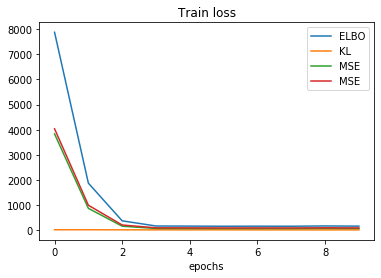

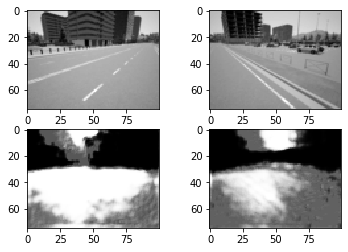

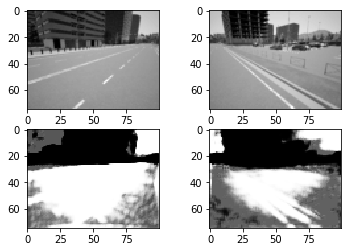

In [8]:
def train(net, optimizer, criterion, epochs, batch, exp_name):
    model = net.to(device)
    total_step = 0
    losses = []
    kl_loss = []
    mseX_loss = []
    mseY_loss = []
    for epoch in range(epochs):
        model.train()
        total = 0
        running_loss = 0.0
        kl_running = 0.0
        mseX_running = 0.0
        mseY_running = 0.0

        for i, X in enumerate(dl):
            left_image_t = X[0][:, 1, :, :, :] # left/right images of t
            right_image_t = X[0][:, 0, :, :, :] # left/right images of t
            # img2 = X[1] # left/right of t+1 # xcxc do the same indexing above to get l/r of t+1

            left_image_t = (left_image_t).float().to(device)
            right_image_t = (right_image_t).float().to(device)

            xhat, yhat, z, z_mean, z_logvar = model.forward(left_image_t,right_image_t)
            loss, MSE_X, MSE_Y, KLD = criterion(xhat,left_image_t, yhat, right_image_t, z_mean, z_logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_step += 1

            running_loss += loss.item()
            kl_running += KLD.item()
            mseX_running += MSE_X.item()
            mseY_running += MSE_Y.item()
            total += batch

            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            # if i == 25:
                # break

        if (epoch+1) % 5 == 0:
            for param_group in optimizer.param_groups:
                print("Current learning rate is: {}".format(param_group['lr']))
            chpt_path = '/content/drive/My Drive/Colab_Notebooks/ESE546_DL_Colab/project/checkpoints/'+exp_name+'.pt'
            torch.save(model.state_dict(), chpt_path)

        losses.append(running_loss/total)     
        kl_loss.append(kl_running/total)
        mseX_loss.append(mseX_running/total)
        mseY_loss.append(mseY_running/total)  
    
    ells = {'elbo':losses,
            'kl':kl_loss,
            'mseX':mseX_loss,
            'mseY':mseY_loss}

    with open('/content/drive/My Drive/Colab_Notebooks/ESE546_DL_Colab/project/logs/'+exp_name+'_losses.pickle', 'wb') as f:
        pickle.dump(ells, f)

    left = []
    right = []
    recon_left = []
    recon_right = []
    for i, X in enumerate(dl):
        model.eval()
        left_image_t = (X[0][:, 1, :, :, :]).float().to(device) # left/right images of t
        right_image_t = (X[0][:, 0, :, :, :]).float().to(device) # left/right images of t
        ctrl_inputs = X[2]

        #Forward Pass
        xhat, yhat, z, z_mean, z_stdev = model.forward(left_image_t,right_image_t)

        left_ = left_image_t.cpu().squeeze().numpy()
        right_ = right_image_t.cpu().squeeze().numpy()
        xhat_ = xhat.cpu().detach().squeeze().numpy()
        yhat_ = yhat.cpu().detach().squeeze().numpy()

        left.append(left_)
        right.append(right_)
        recon_left.append(xhat_)
        recon_right.append(yhat_)
        if i == 40:
            break
    left = np.asarray(left)
    right = np.asarray(right)
    recon_left = np.asarray(recon_left)
    recon_right = np.asarray(recon_right)

    plt.plot(losses, label='ELBO')
    plt.plot(kl_loss, label='KL')
    plt.plot(mseX_loss, label='MSE')
    plt.plot(mseY_loss, label='MSE')
    plt.title('Train loss')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()
    plt.subplot(221)
    plt.imshow(left[0], cmap = 'gray')
    plt.subplot(222)
    plt.imshow(right[0], cmap = 'gray')
    plt.subplot(223)
    plt.imshow(recon_left[0], cmap = 'gray')
    plt.subplot(224)
    plt.imshow(recon_right[0], cmap = 'gray')
    plt.figure()
    plt.subplot(221)
    plt.imshow(left[30], cmap = 'gray')
    plt.subplot(222)
    plt.imshow(right[30], cmap = 'gray')
    plt.subplot(223)
    plt.imshow(recon_left[30], cmap = 'gray')
    plt.subplot(224)
    plt.imshow(recon_right[30], cmap = 'gray')


#Run from here
exp_name = 'siamese_41616_smalllr'
model = siameseCVAE(batch=batch)
# checkpoint = torch.load('/content/drive/My Drive/Colab_Notebooks/ESE546_DL_Colab/project/checkpoints/siamese_doublecam.pt')
# model.load_state_dict(checkpoint) 

epochs = 10
criterion = ELBO_loss
optimizer = optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-3)

train(model, optimizer, criterion, epochs, batch, exp_name)

Evaluate Checkpoint

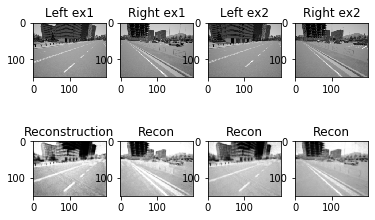

In [11]:
def train(net, optimizer, criterion, epochs):
    model = net.to(device)    
    left = []
    right = []
    recon_left = []
    recon_right = []
    for i, X in enumerate(dl):
        model.eval()
        left_image_t = (X[0][:, 1, :, :, :]).float().to(device) # left/right images of t
        right_image_t = (X[0][:, 0, :, :, :]).float().to(device) # left/right images of t
        ctrl_inputs = X[2]

        #Forward Pass
        xhat, yhat, z, z_mean, z_stdev = model.forward(left_image_t,right_image_t)

        color = False
        left_ = _rearrange_channel_last(left_image_t.cpu(), color)
        right_ = _rearrange_channel_last(right_image_t.cpu(), color)
        xhat_ = _rearrange_channel_last(xhat.cpu().detach().numpy(), color)
        yhat_ = _rearrange_channel_last(yhat.cpu().detach().numpy(), color)
        left.append(left_)
        right.append(right_)
        recon_left.append(xhat_)
        recon_right.append(yhat_)
        if i == 25:
            break
    left = np.asarray(left)
    right = np.asarray(right)
    recon_left = np.asarray(recon_left)
    recon_right = np.asarray(recon_right)


    ex1, ex2 = 0, 25
    plt.figure()
    plt.subplot(241)
    plt.imshow(left[ex1], cmap = 'gray')
    plt.title('Left ex1')
    plt.subplot(242)
    plt.imshow(right[ex1], cmap = 'gray')
    plt.title('Right ex1')
    plt.subplot(245)
    plt.imshow(recon_left[ex1], cmap = 'gray')
    plt.title('Reconstruction')
    plt.subplot(246)
    plt.imshow(recon_right[ex1], cmap = 'gray')
    plt.title('Recon')
    # plt.figure()
    plt.subplot(243)
    plt.imshow(left[ex2], cmap = 'gray')
    plt.title('Left ex2')
    plt.subplot(244)
    plt.imshow(right[ex2], cmap = 'gray')
    plt.title('Right ex2')
    plt.subplot(247)
    plt.imshow(recon_left[ex2], cmap = 'gray')
    plt.title('Recon')
    plt.subplot(248)
    plt.imshow(recon_right[ex2], cmap = 'gray')
    plt.title('Recon')


#Run from here
model = siameseCVAE(batch=batch)
checkpoint = torch.load('/content/drive/My Drive/Colab_Notebooks/ESE546_DL_Colab/project/checkpoints/siamese_chpt.pt')
model.load_state_dict(checkpoint) 

epochs = 1
criterion = ELBO_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-3)

train(model, optimizer, criterion, epochs)